<a id="27017"></a>
##  Process Flow


* [Reading data and feature engineering](#1)

* [Exploratory Data Analaysis](#1_2)
    - [Skewness for all 4 Bearings](#1_2_1)
    - [Kurtosis for all 4 Bearings](#1_2_2)
    - [Root Mean Square for all 4 bearings](#1_2_3)
    - [ Rms grapgh for Individual Bearing](#1_2_5)
    - [Histogram for data after 16days, skewness for bearing 1](#1_2_4)
    
* [Statistical Analysis and Data Preparation using PDF,CDF, WEIBULL hazard rate](#1_3)

####  Also using  Tress based ensamble model, not CHAID ( that uses adjusted significance testing) but  other boosting models thats learns using weight adjustment or past errors.

* [Modeling and evaluation](#1_4)
    - [Multi Layer Perceptron](#1_4_1)
    - [XGBOOST](#1_4_2)
    - [LIGHTGBM](#1_4_3)
    - [Gradient Boosting Machine](#1_4_4)
    
* [Performace on Test](#1_5)

* [Modeling for all the 4 bearings](#1_6)



### Results


##  [Deliverable](#123) 



### IMPORTS

In [1]:
import pandas as pd
from io import StringIO
import numpy as np
import seaborn as sb
import math
import os
import time
from collections import OrderedDict
from scipy.stats import kurtosis, skew, exponweib, norm, weibull_min
import re
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import keras
from  matplotlib  import pylab 
from scipy.ndimage import gaussian_filter1d
%matplotlib inline

Using TensorFlow backend.


<a id="1"></a>
### Reading data and feature engineering

[Top](#27017)

In [2]:
listpath = os.walk(os.getcwd()+"/2nd_test/")

In [3]:
all_path = []
for i in listpath:
    all_path.append(i)

In [4]:
rms_list_all_events = []
columns = ["B1","B2","B3","B4"]
for i in range(len(all_path[0][2])):
    if all_path[0][2][i] == ".DS_Store": 
        print("ignore string")
    else :
        path = all_path[0][0] + all_path[0][2][i]
        df = pd.read_csv(path, sep='\t', names=columns)
        rmsB1 = np.sqrt(np.mean(df.B1**2))
        kurtosis1 = kurtosis(df.B1)
        stdn1 = np.sqrt(np.sum((np.array(df.B1) - np.mean(df.B1))**2)/(len(df.B1)-1))
        mean1 = np.mean(df.B1)
        skew1 = skew(df.B1)

        rmsB2 = np.sqrt(np.mean(df.B2**2))
        kurtosis2 = kurtosis(df.B2)
        stdn2 = np.sqrt(np.sum((np.array(df.B2) - np.mean(df.B2))**2)/(len(df.B2)-1))
        mean2 = np.mean(df.B2)
        skew2 = skew(df.B2)

        rmsB3 = np.sqrt(np.mean(df.B3**2))
        kurtosis3 = kurtosis(df.B3)
        stdn3 = np.sqrt(np.sum((np.array(df.B3) - np.mean(df.B3))**2)/(len(df.B3)-1))
        mean3 = np.mean(df.B3)
        skew3 = skew(df.B3)

        rmsB4 = np.sqrt(np.mean(df.B4**2))
        kurtosis4 = kurtosis(df.B4)
        stdn4 = np.sqrt(np.sum((np.array(df.B4) - np.mean(df.B4))**2)/(len(df.B4)-1))
        mean4 = np.mean(df.B4)
        skew4 = skew(df.B4)

        dateString = all_path[0][2][i]
        str_dt = dateString[:10].replace(".","-")+ " " + dateString[11:].replace(".",":")

        datetime_object = datetime.strptime(str_dt, '%Y-%m-%d %H:%M:%S')

        timestamp = int(time.mktime(datetime_object.timetuple()))

        data  = {"rmsB1": rmsB1, "rmsB2":rmsB2, "rmsB3":rmsB3, "rmsB4":rmsB4,
                 "time": datetime_object.time(), "date_time_format" : datetime_object, "day":datetime_object.date().day,
                 "hour":datetime_object.time().hour, "date_time": timestamp,
                 "date":datetime_object.date(),"kurtosis1": kurtosis1, "kurtosis2": kurtosis2,
                 "kurtosis3":kurtosis3, "kurtosis4":kurtosis4,"skew1":skew1, "skew2":skew2,
                 "skew3":skew3, "skew4":skew4, "stdn1":stdn1, "stdn2": stdn2, "stdn3":stdn3,
                 "stdn4":stdn4, "mean1":mean1, "mean2":mean2, "mean3":mean3, "mean4":mean4,
                "year":datetime_object.date().year,"month":datetime_object.date().month, 
                "day":datetime_object.date().day,"hour":datetime_object.time().hour,
                 "minute":datetime_object.time().minute,"second":datetime_object.time().second}

        rms_list_all_events.append(data)

ignore string


In [5]:
rms_df  = pd.DataFrame(rms_list_all_events)

In [6]:
rms_df.sort_values(["date_time"], axis=0, ascending=[True], inplace=True)

In [7]:
rms_df = rms_df.reset_index(drop=True)
#rms_df.to_csv("rms_df.csv", sep=",")

In [8]:
rms_df

date   date_time    date_time_format  day  hour  kurtosis1  \
0    2004-02-12  1076562159 2004-02-12 10:32:39   12    10   0.628763   
1    2004-02-12  1076562759 2004-02-12 10:42:39   12    10   0.648291   
2    2004-02-12  1076563359 2004-02-12 10:52:39   12    10   0.513475   
3    2004-02-12  1076563959 2004-02-12 11:02:39   12    11   1.157953   
4    2004-02-12  1076564559 2004-02-12 11:12:39   12    11   0.603177   
5    2004-02-12  1076565159 2004-02-12 11:22:39   12    11   0.456094   
6    2004-02-12  1076565759 2004-02-12 11:32:39   12    11   0.478615   
7    2004-02-12  1076566359 2004-02-12 11:42:39   12    11   0.471982   
8    2004-02-12  1076566959 2004-02-12 11:52:39   12    11   0.404514   
9    2004-02-12  1076567559 2004-02-12 12:02:39   12    12   0.325203   
10   2004-02-12  1076568159 2004-02-12 12:12:39   12    12   0.455212   
11   2004-02-12  1076568759 2004-02-12 12:22:39   12    12   0.641515   
12   2004-02-12  1076569359 2004-02-12 12:32:39   12    12   0.364726   
13   2004-02-12  1076569959 2004-02-12 12:42:39   12    12   0.598253   
14   2004-02-12  1076570559 2004-02-12 12:52:39   12    12   0.551110   
15   2004-02-12  1076571159 2004-02-12 13:02:39   12    13   0.553052   
16   2004-02-12  1076571759 2004-02-12 13:12:39   12    13   0.479966   
17   2004-02-12  1076572359 2004-02-12 13:22:39   12    13   0.447749   
18   2004-02-12  1076572959 2004-02-12 13:32:39   12    13   0.341445   
19   2004-02-12  1076573559 2004-02-12 13:42:39   12    13   0.596430   
20   2004-02-12  1076574159 2004-02-12 13:52:39   12    13   0.506380   
21   2004-02-12  1076574759 2004-02-12 14:02:39   12    14   0.384407   
22   2004-02-12  1076575359 2004-02-12 14:12:39   12    14   0.414972   
23   2004-02-12  1076575959 2004-02-12 14:22:39   12    14   0.520074   
24   2004-02-12  1076576559 2004-02-12 14:32:39   12    14   0.484681   
25   2004-02-12  1076577159 2004-02-12 14:42:39   12    14   0.309976   
26   2004-02-12  1076577759 2004-02-12 14:52:39   12    14   0.368042   
27   2004-02-12  1076578359 2004-02-12 15:02:39   12    15   0.404208   
28   2004-02-12  1076578959 2004-02-12 15:12:39   12    15   0.341992   
29   2004-02-12  1076579559 2004-02-12 15:22:39   12    15   0.535020   
..          ...         ...                 ...  ...   ...        ...   
954  2004-02-19  1077134559 2004-02-19 01:32:39   19     1   0.612475   
955  2004-02-19  1077135159 2004-02-19 01:42:39   19     1   0.561138   
956  2004-02-19  1077135759 2004-02-19 01:52:39   19     1   0.465567   
957  2004-02-19  1077136359 2004-02-19 02:02:39   19     2   0.168745   
958  2004-02-19  1077136959 2004-02-19 02:12:39   19     2   0.819911   
959  2004-02-19  1077137559 2004-02-19 02:22:39   19     2   0.500932   
960  2004-02-19  1077138159 2004-02-19 02:32:39   19     2   0.570946   
961  2004-02-19  1077138759 2004-02-19 02:42:39   19     2   0.168281   
962  2004-02-19  1077139359 2004-02-19 02:52:39   19     2   0.293096   
963  2004-02-19  1077139959 2004-02-19 03:02:39   19     3   0.446315   
964  2004-02-19  1077140559 2004-02-19 03:12:39   19     3   0.162353   
965  2004-02-19  1077141159 2004-02-19 03:22:39   19     3   0.466872   
966  2004-02-19  1077141759 2004-02-19 03:32:39   19     3   0.173705   
967  2004-02-19  1077142359 2004-02-19 03:42:39   19     3  -0.264541   
968  2004-02-19  1077142959 2004-02-19 03:52:39   19     3  -0.258874   
969  2004-02-19  1077143559 2004-02-19 04:02:39   19     4   1.596144   
970  2004-02-19  1077144159 2004-02-19 04:12:39   19     4   2.237255   
971  2004-02-19  1077144759 2004-02-19 04:22:39   19     4   6.022867   
972  2004-02-19  1077145359 2004-02-19 04:32:39   19     4   2.710835   
973  2004-02-19  1077145959 2004-02-19 04:42:39   19     4   8.787365   
974  2004-02-19  1077146559 2004-02-19 04:52:39   19     4   3.161553   
975  2004-02-19  1077147159 2004-02-19 05:02:39   19     5  14.110009   
976  2004-02-19  1077147759 2004-02-19 05:12:39   19     5   9.796461

<a id="1_2"></a>
### Exploratory Data Analaysis 

[Top](#27017)

#### Plotting standard deviation of rms, skew, kurtosis for all the events recorded

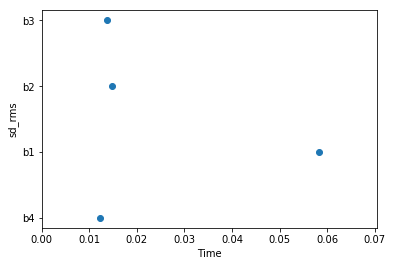

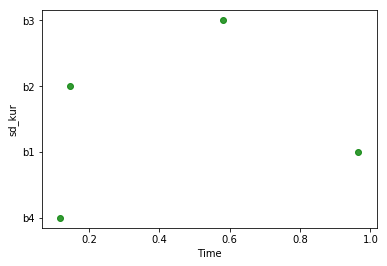

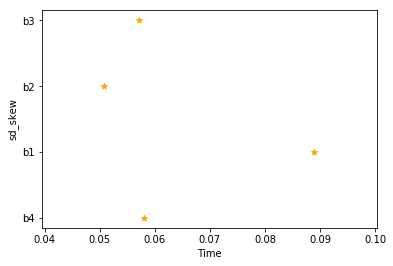

In [9]:
rms = []
stdb1 = np.sqrt(np.mean(abs(rms_df.rmsB1 - rms_df.rmsB1.mean())**2))
stdb2 = np.sqrt(np.mean(abs(rms_df.rmsB2 - rms_df.rmsB2.mean())**2))
stdb3 = np.sqrt(np.mean(abs(rms_df.rmsB3 - rms_df.rmsB3.mean())**2))
stdb4 = np.sqrt(np.mean(abs(rms_df.rmsB4 - rms_df.rmsB4.mean())**2))
dictstd = OrderedDict({"b1":stdb1,"b2":stdb2, "b3":stdb3, "b4":stdb4})
rms.append(dictstd)
plt.scatter(rms[0].values(),rms[0].keys())
plt.xlabel('Time')
plt.ylabel('sd_rms')
plt.show()

kur = []
k1 = np.sqrt(np.mean(abs(rms_df.kurtosis1 - rms_df.kurtosis1.mean())**2))
k2 = np.sqrt(np.mean(abs(rms_df.kurtosis2 - rms_df.kurtosis2.mean())**2))
k3 = np.sqrt(np.mean(abs(rms_df.kurtosis3 - rms_df.kurtosis3.mean())**2))
k4 = np.sqrt(np.mean(abs(rms_df.kurtosis4 - rms_df.kurtosis4.mean())**2))
dictstd = {"b1":k1, "b2":k2, "b3":k3, "b4":k4}
kur.append(dictstd)
plt.scatter(kur[0].values(),kur[0].keys(), alpha=0.8, c="green")
plt.xlabel('Time')
plt.ylabel('sd_kur')
plt.show()

skw = []
s1 = np.sqrt(np.mean(abs(rms_df.skew1 - rms_df.skew1.mean())**2))
s2 = np.sqrt(np.mean(abs(rms_df.skew2 - rms_df.skew2.mean())**2))
s3 = np.sqrt(np.mean(abs(rms_df.skew3 - rms_df.skew3.mean())**2))
s4 = np.sqrt(np.mean(abs(rms_df.skew4 - rms_df.skew4.mean())**2))
plt.xlabel('Time')
plt.ylabel('sd_skew')
dictstd = {"b1":s1, "b2":s2, "b3":s3, "b4":s4}
skw.append(dictstd)
plt.scatter(skw[0].values(),skw[0].keys(), marker="*", c="orange")
plt.show()

<a id="1_2_1"></a>
#### Skewness for all 4 Bearings

No of Events recorded : 984


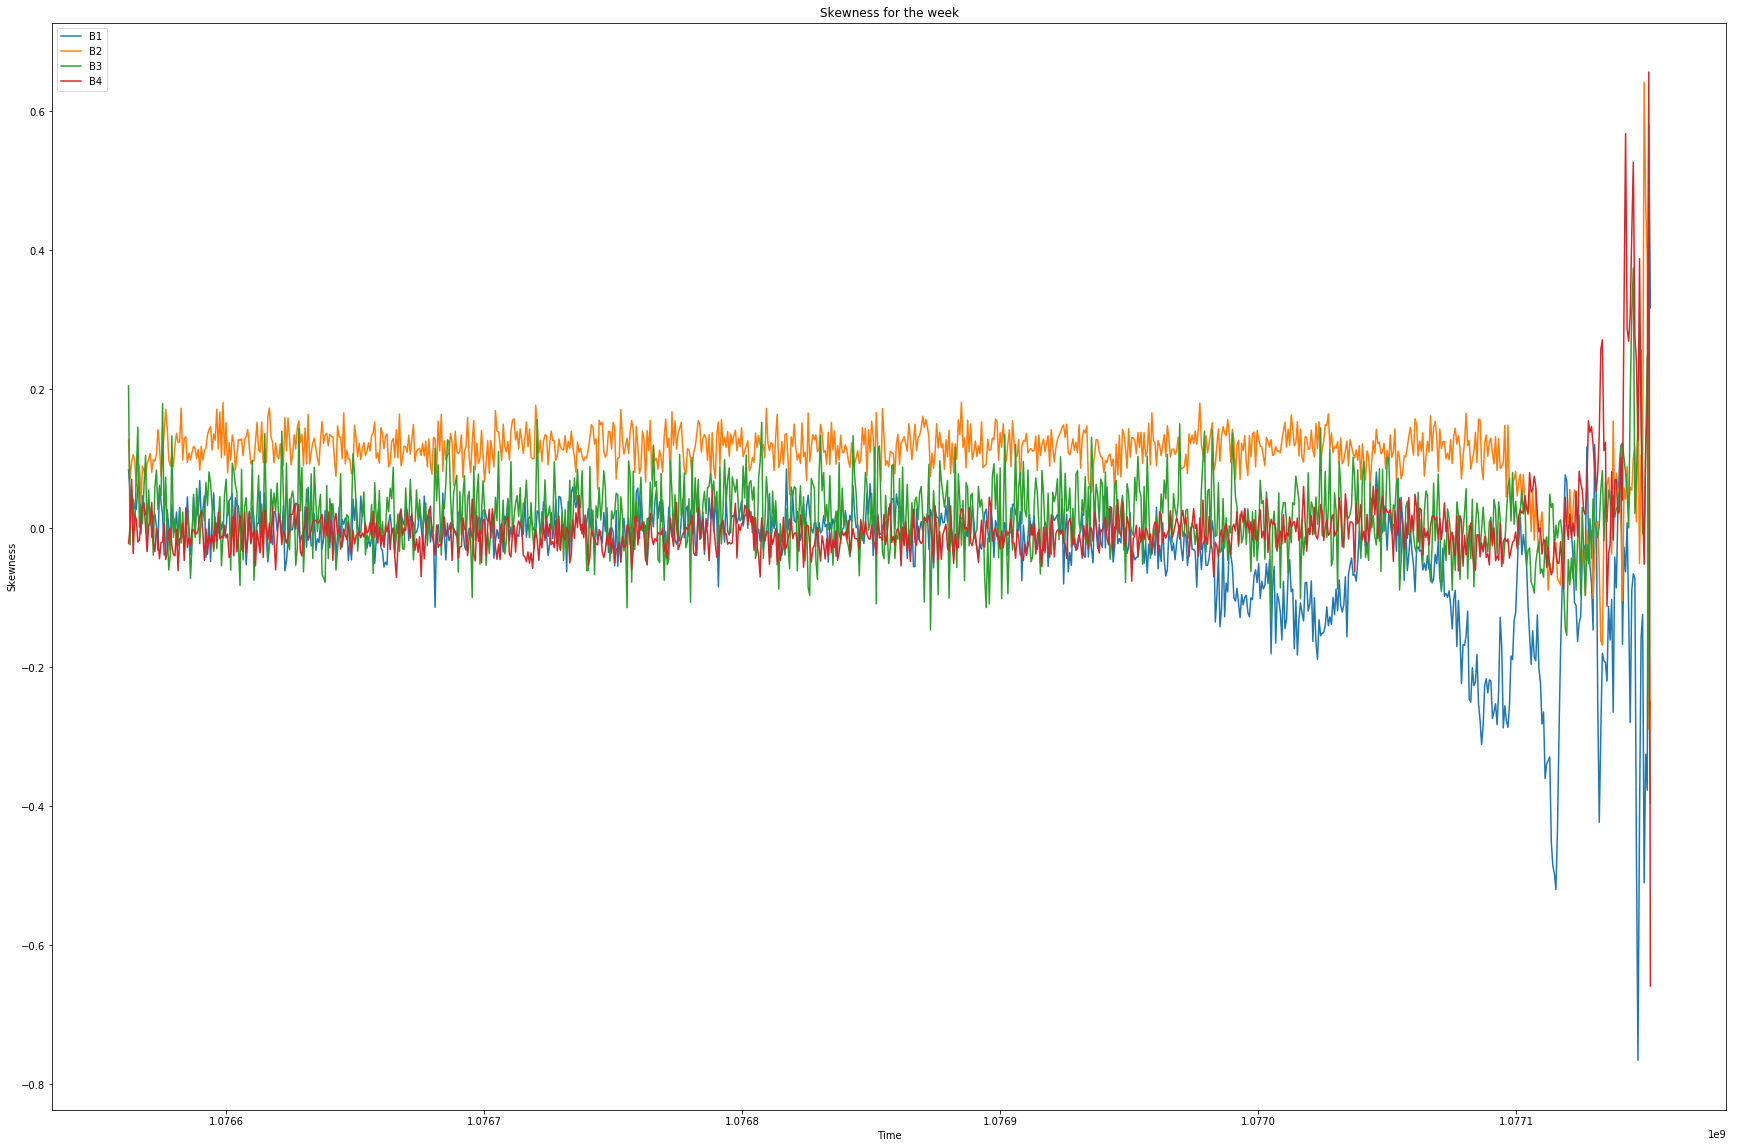

In [10]:
plt.figure(figsize=(30,20))
print "No of Events recorded :", len(rms_df)

plt.title("Skewness for the week")
plt.xlabel('Time')
plt.ylabel('Skewness')
plt.plot(rms_df.date_time,rms_df.skew1, label="B1")
plt.plot(rms_df.date_time,rms_df.skew2, label="B2")
plt.plot(rms_df.date_time,rms_df.skew3, label="B3")
plt.plot(rms_df.date_time,rms_df.skew4,  label="B4")
plt.legend(loc='upper left')

pylab.savefig('skewnessbearings.png')

<a id="1_2_2"></a>
#### Kurtosis for all 4 Bearings

* [Deliverable](#123)

No of Events recorded : 984


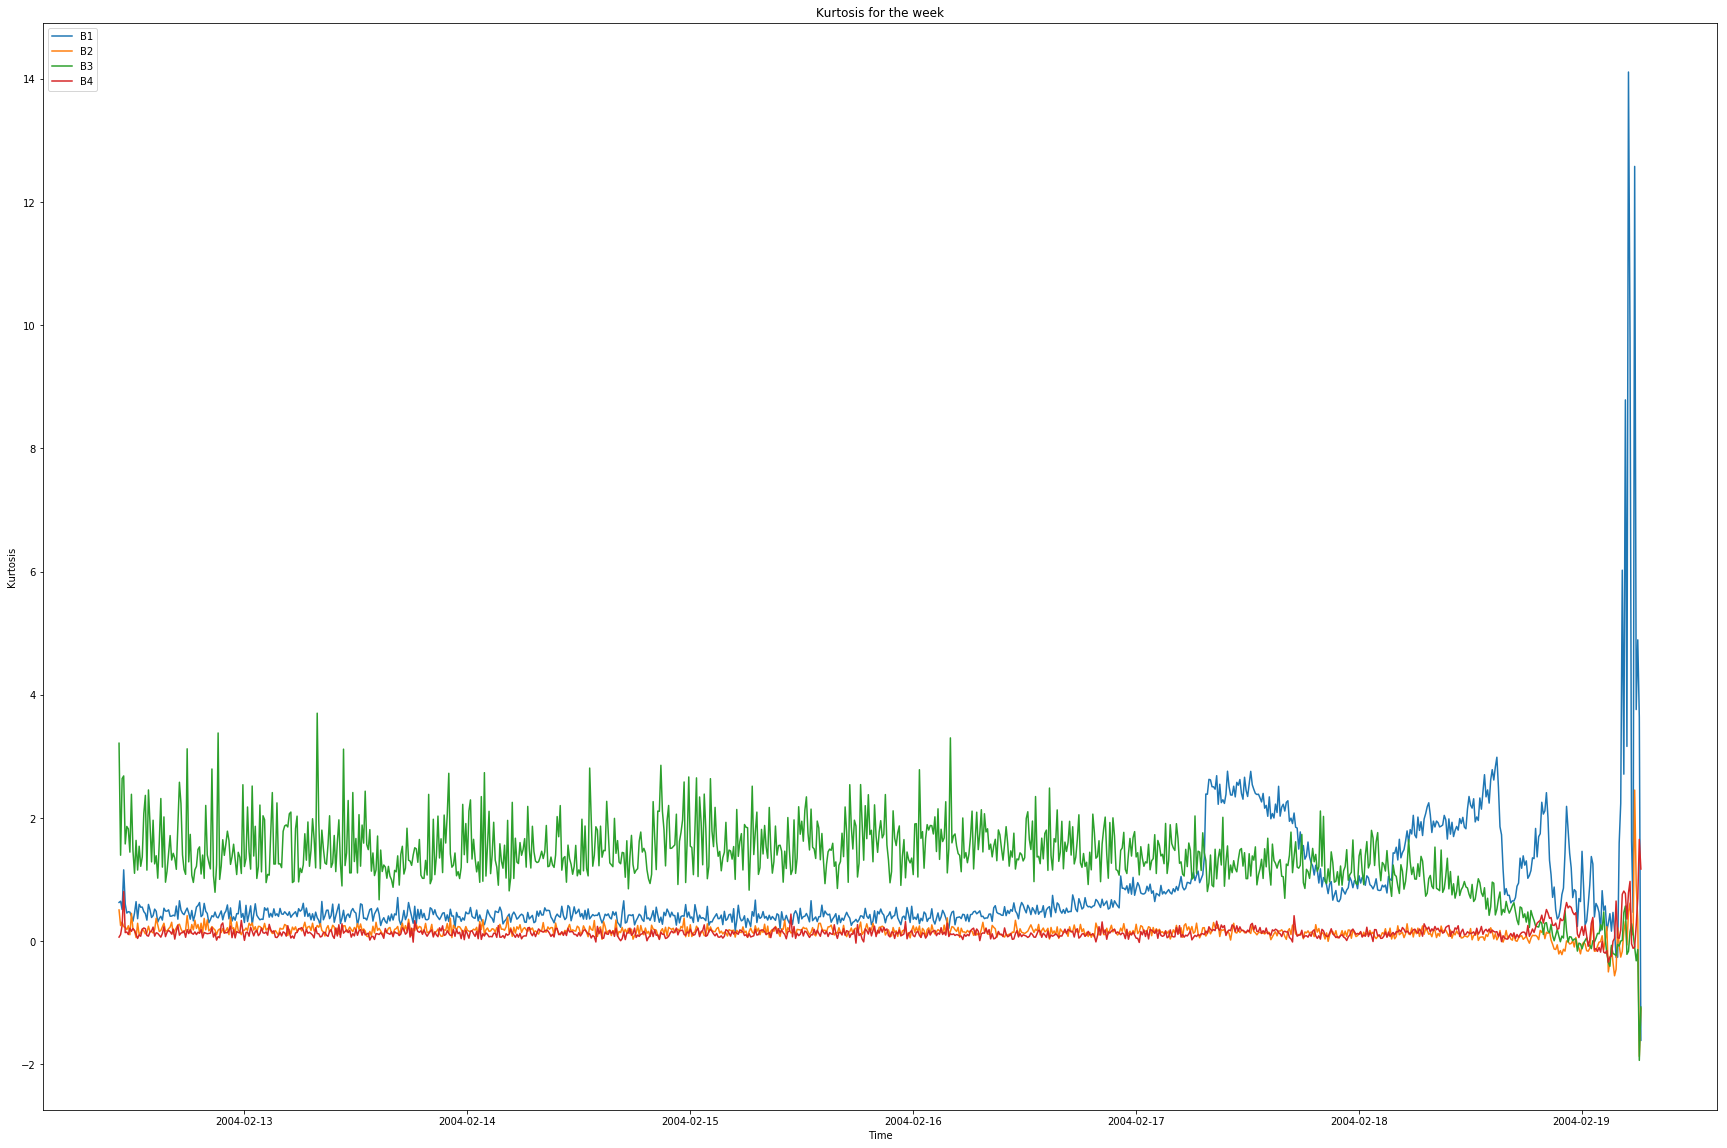

In [11]:
plt.figure(figsize=(30,20))
print "No of Events recorded :", len(rms_df)
plt.title("Kurtosis for the week")
plt.xlabel('Time')
plt.ylabel('Kurtosis')
plt.plot(rms_df.date_time_format, rms_df.kurtosis1, label="B1")
plt.plot(rms_df.date_time_format, rms_df.kurtosis2, label="B2")
plt.plot(rms_df.date_time_format, rms_df.kurtosis3, label="B3")
plt.plot(rms_df.date_time_format, rms_df.kurtosis4,  label="B4")
plt.legend(loc='upper left')

pylab.savefig('Kurtosisbearings.png')

<a id="1_2_3"></a>
#### Root Mean Square for all 4 bearings


* [Deliverable](#123)

No of Events recorded : 984


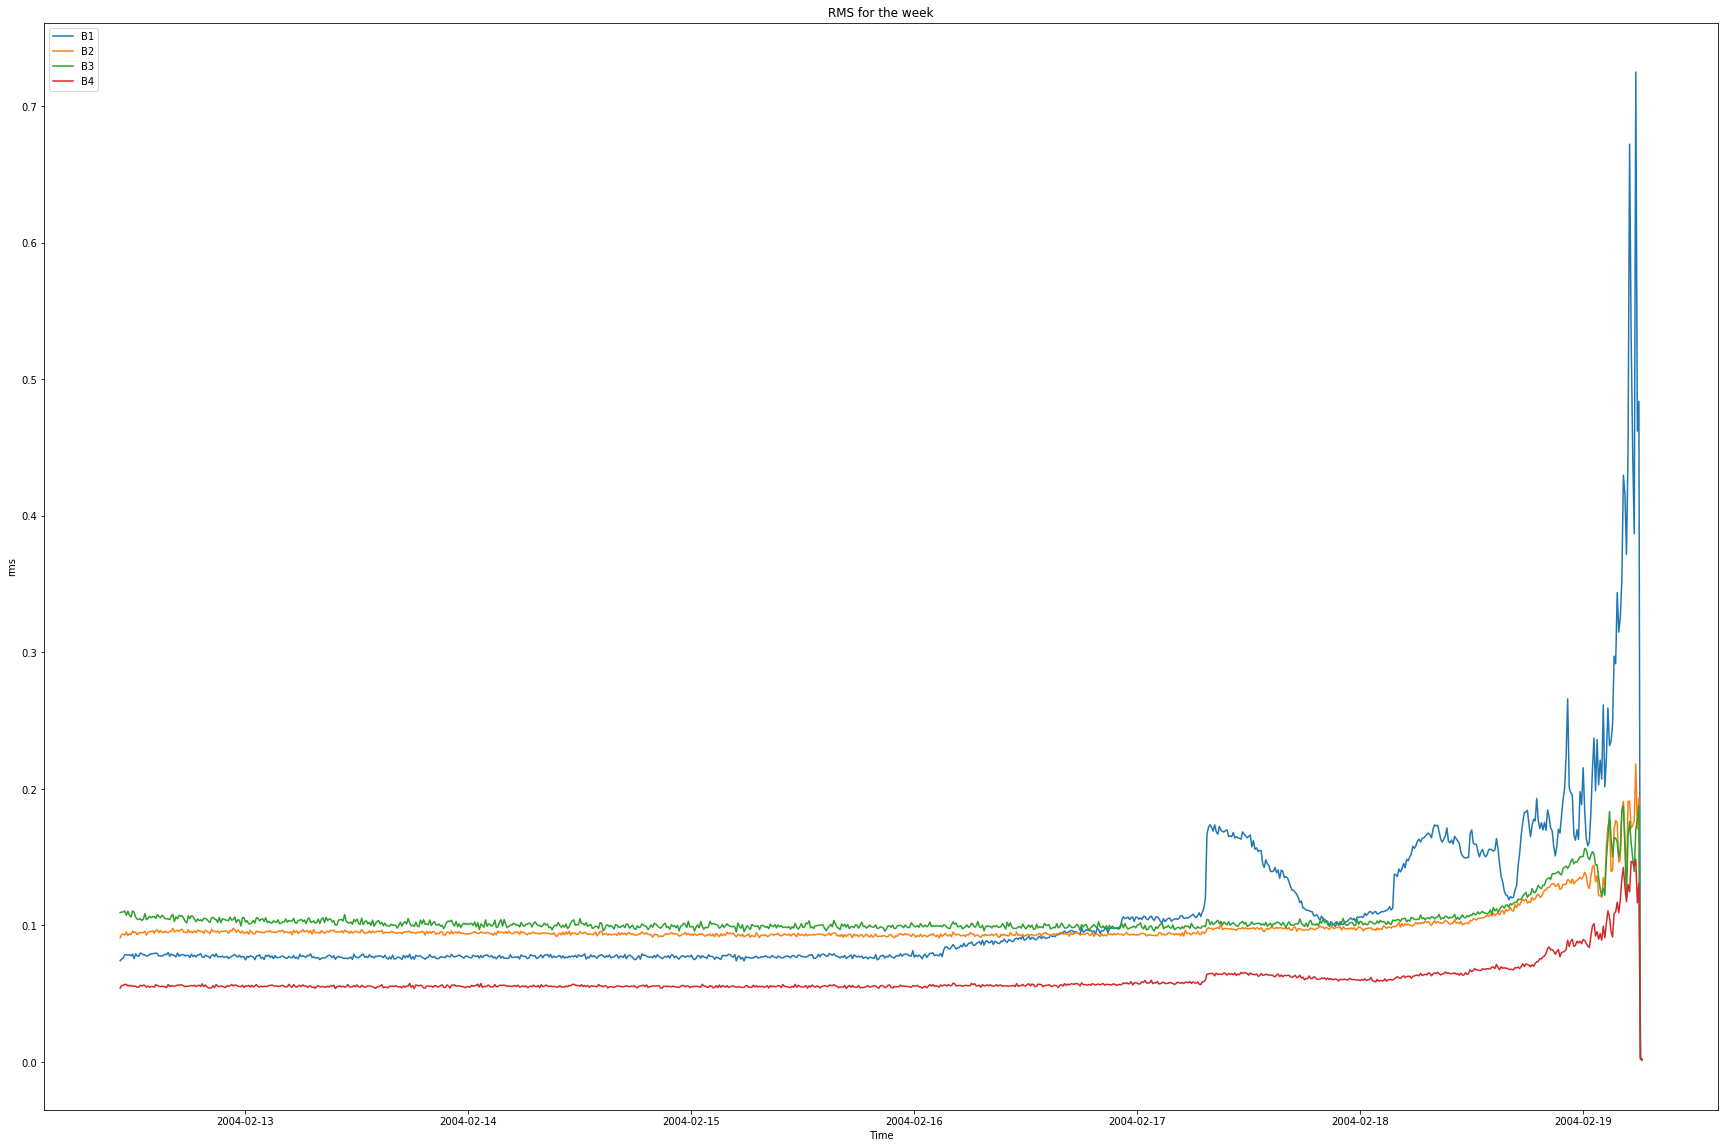

In [12]:
plt.figure(figsize=(30,20))
print "No of Events recorded :", len(rms_df)

plt.title("RMS for the week")
plt.xlabel('Time')
plt.ylabel('rms')
plt.plot(rms_df.date_time_format,rms_df.rmsB1, label="B1")
plt.plot(rms_df.date_time_format,rms_df.rmsB2, label="B2")
plt.plot(rms_df.date_time_format,rms_df.rmsB3, label="B3")
plt.plot(rms_df.date_time_format,rms_df.rmsB4,  label="B4")
plt.legend(loc='upper left')

pylab.savefig('rmsbearings.png')

<a id="1_2_5"></a>
#### Rms grapgh for Individual Bearing

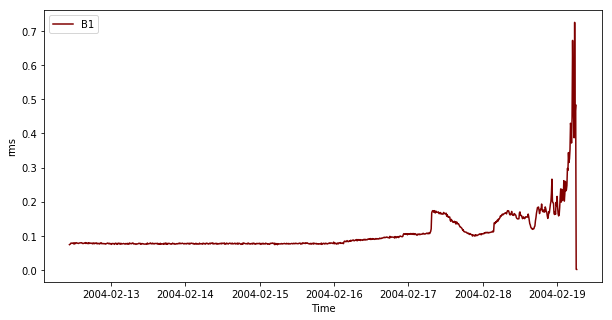

<Figure size 432x288 with 0 Axes>

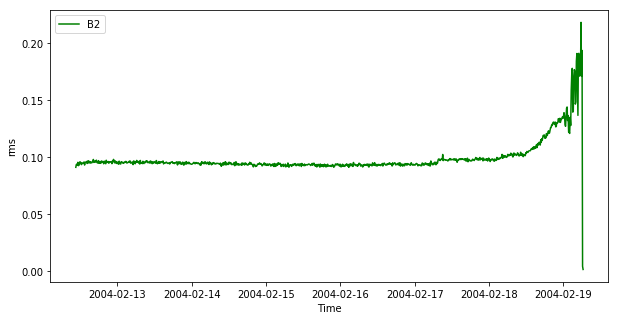

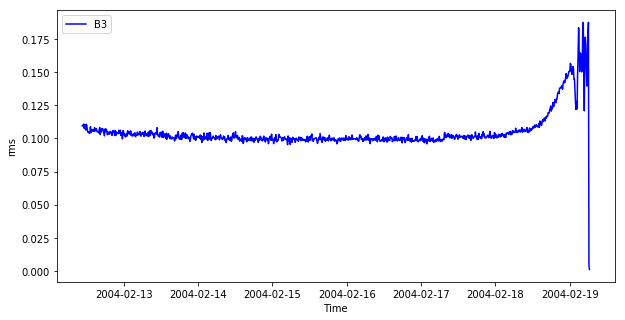

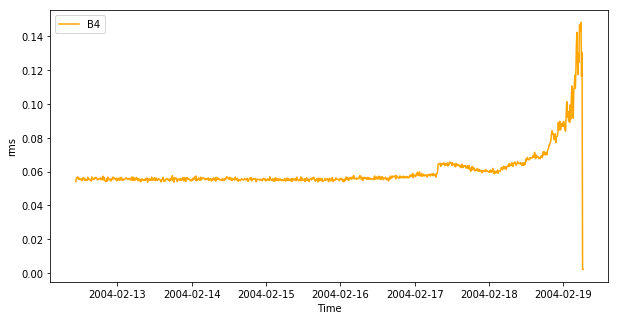

In [13]:
#individual RMS value
plt.figure(figsize=(10,5))
plt.plot(rms_df.date_time_format, rms_df.rmsB1,label="B1", c="maroon")
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('rms')
plt.show()
pylab.savefig("B1rms.png")

plt.figure(figsize=(10,5))
plt.plot(rms_df.date_time_format, rms_df.rmsB2, label="B2", c="green")
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('rms')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rms_df.date_time_format,rms_df.rmsB3, label="B3", c= "blue")
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('rms')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rms_df.date_time_format, rms_df.rmsB4, label="B4", c= "orange")
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('rms')
plt.show()

<a id="1_2_4"></a>
#### Histogram for data after 16days, skewness for bearing 1

No of Events recorded : 984


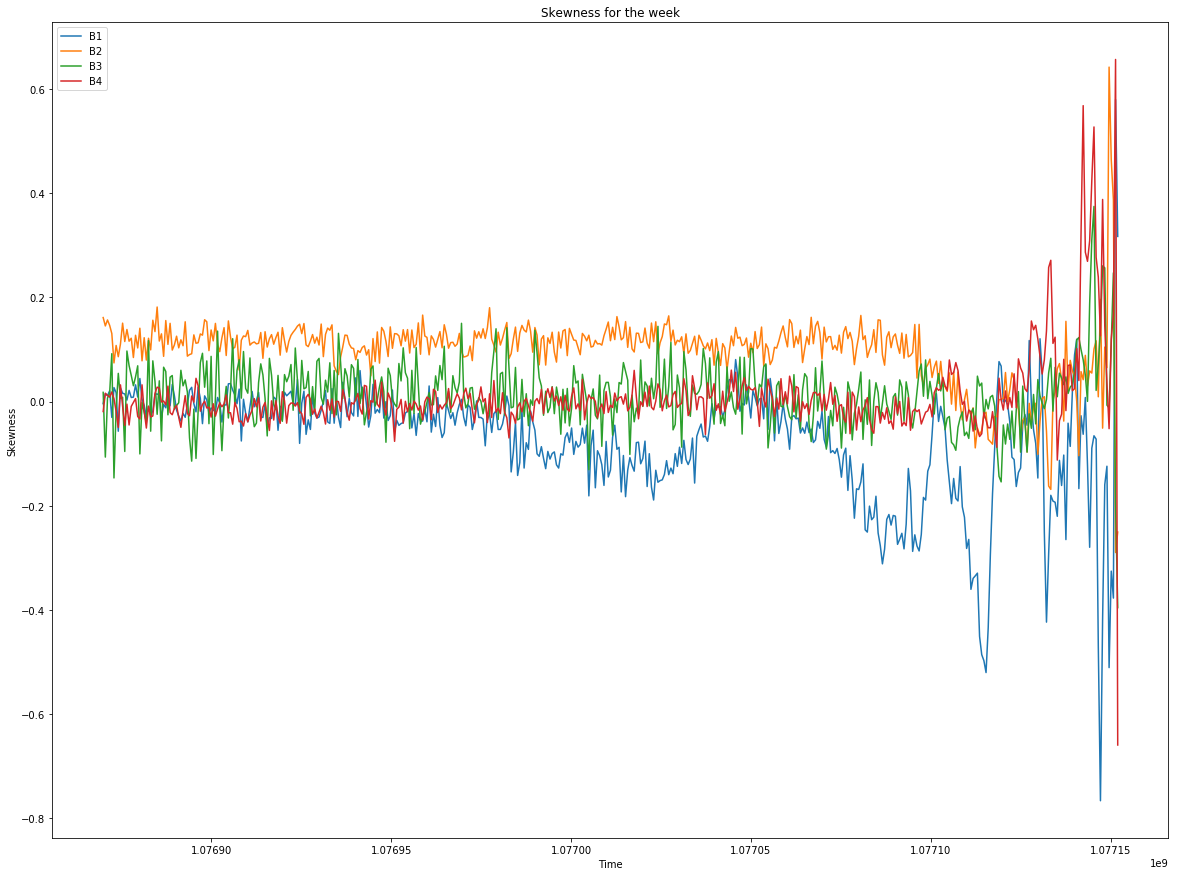

In [14]:
filterred_data16  = rms_df[rms_df.day >= 16]
plt.figure(figsize=(20,15))
print "No of Events recorded :", len(rms_df)

plt.title("Skewness for the week")
plt.xlabel('Time')
plt.ylabel('Skewness')
plt.plot(filterred_data16.date_time,filterred_data16.skew1, label="B1")
plt.plot(filterred_data16.date_time,filterred_data16.skew2, label="B2")
plt.plot(filterred_data16.date_time,filterred_data16.skew3, label="B3")
plt.plot(filterred_data16.date_time,filterred_data16.skew4,  label="B4")
plt.legend(loc='upper left')

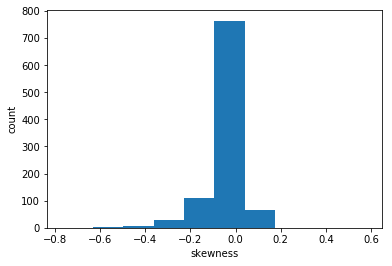

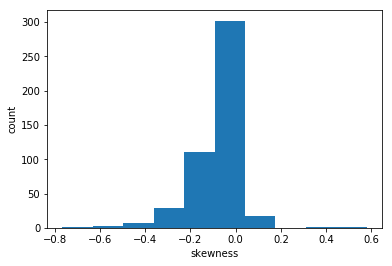

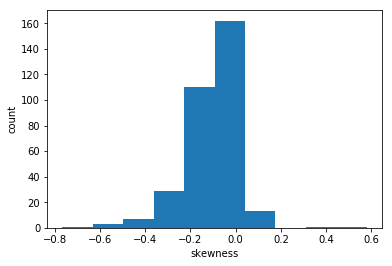

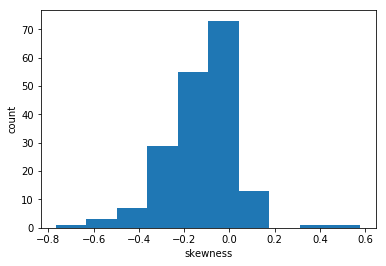

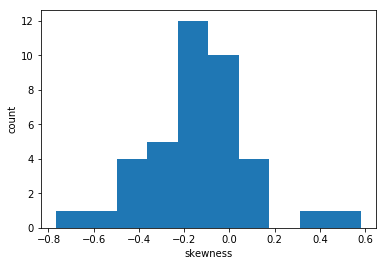

In [15]:
#plotting data for 16,17,18,19 days for bearing 1
plt.hist(rms_df.skew1)
plt.xlabel('skewness')
plt.ylabel('count')
plt.show()
for days in [16, 17, 18, 19]:
    filterred_data  = rms_df[rms_df.day >= days]
    plt.hist(filterred_data.skew1)
    plt.xlabel('skewness')
    plt.ylabel('count')
    plt.show()

<a id="1_3"></a>
### Statistical Analysis and Data Preparation using PDF, CDF, WEIBULL hazard rate

[Top](#27017)

In [29]:
# Getting the parameters shape and scale of Weibull hazard  distribution
shaperms1,locrm1,scalerms1 = weibull_min.fit(rms_df.rmsB1, floc=0)
shapekrt1,lockr1,scalekrt1 = weibull_min.fit(rms_df.kurtosis1, floc=0)

### elapsed time can't be delivered as date_time or string so converting into
#timestamp (above code for Feature Creation) and then normalizing it. 
elapsed_time = np.array(rms_df.date_time)
elapsed_time1 = (elapsed_time)/np.mean(elapsed_time)

## Cumulative  density  function
life_percentage = (1 - np.exp(- elapsed_time1/scalerms1)**shaperms1)
life_percentage_time = (life_percentage-min(life_percentage))/(max(life_percentage)-min(life_percentage))
#life_percentage_kurt = 1-np.exp(-(((rms_df.kurtosis1)/(scalekrt1))**(shapekrt1)))

rmsB1_filtered  = gaussian_filter1d(rms_df.rmsB1, 65)
kurtosis1_filtered = gaussian_filter1d(rms_df.kurtosis1, 65)

### Rms fitting pdf
rms_pdf = weibull_min.pdf(rmsB1_filtered, shaperms1, scale=scalerms1)
#rms_fitted = rmsB1_pdf/(1-life_percentage_rms)

###Kurtosis fitting pdf
kurt_pdf = weibull_min.pdf(kurtosis1_filtered, shapekrt1, scale=scalekrt1)
#kurt_fitted = kurtB1_pdf/(1-life_percentage_kurt)

#using the function when there is "inf" value in kurt_fitted
#kurt_fitted = kurt_fitted.replace([np.inf, -np.inf], np.nan)

#kurt_fitted.fillna(method="bfill",inplace=True)

### min_max scaling 
rms_fitted_fin = (rms_pdf-min(rms_pdf))/(max(rms_pdf)-min(rms_pdf))
kurt_fitted_fin = (kurt_pdf-min(kurt_pdf))/(max(kurt_pdf)-min(kurt_pdf))


###previous features 
kurt_rms_previous  = pd.DataFrame({"kurt_fitted" : kurt_fitted_fin , "rms_fitted": rms_fitted_fin,
              "date_time": elapsed_time1, "life_percentage":life_percentage_time})

###current features
current_k_r =  kurt_rms_previous[1:]

kurt_rms_previous.index = kurt_rms_previous.index + 1 #index-restting for joining on index
kurt_rms_previous.drop(['life_percentage'],axis=1, inplace=True)
print (kurt_rms_previous.columns)
kurt_rms_previous.columns = ["date_time_previous",'kurt_fitted_previous','rms_fitted_previous']

###joing current and previous time, rms and kurtosis in the current df
final_df1 = current_k_r.join(kurt_rms_previous)

print (final_df1.columns)

Index([u'date_time', u'kurt_fitted', u'rms_fitted'], dtype='object')
Index([u'date_time', u'kurt_fitted', u'life_percentage', u'rms_fitted',
       u'date_time_previous', u'kurt_fitted_previous', u'rms_fitted_previous'],
      dtype='object')


In [24]:
parameterestimates = pd.DataFrame({"rms" : {"scale":0.11978935984371036,"shape": 1.9366638914705407},
              "kurtosis": {"scale" :0.894702374127291, "shape": 1.2007715159872192}})

<a id="1_4"></a>
### Modeling and evaluation for bearing1

[Top](#27017)

<a id="1_4_1"></a>
#### Multi Layer Perceptron

0.0001232691497088029
0.0001256751563619205
0.00012555277555555643


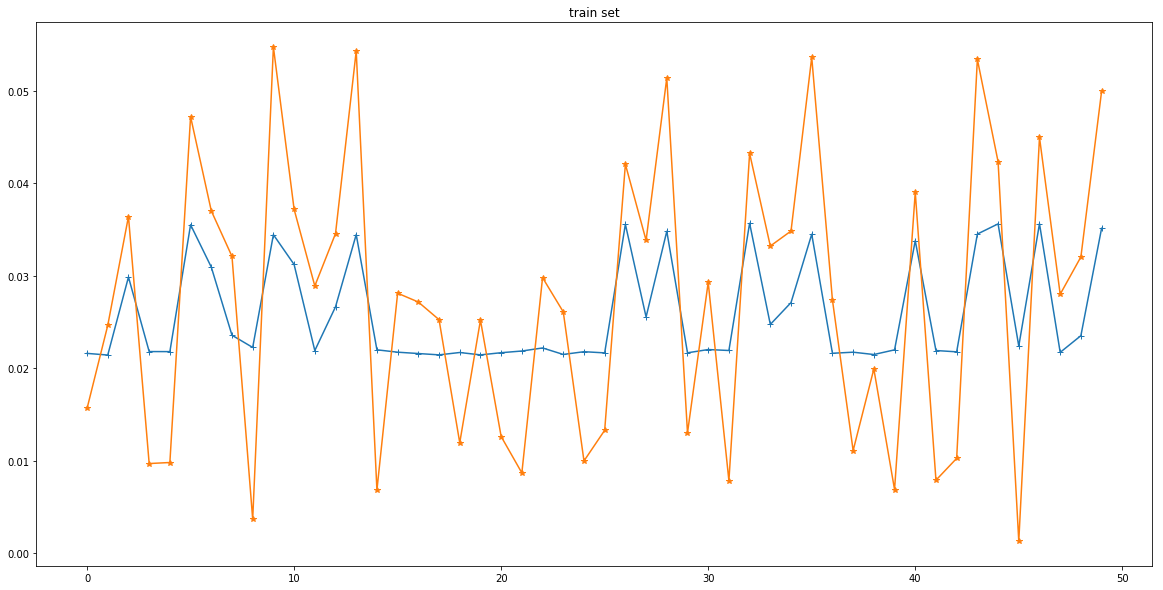

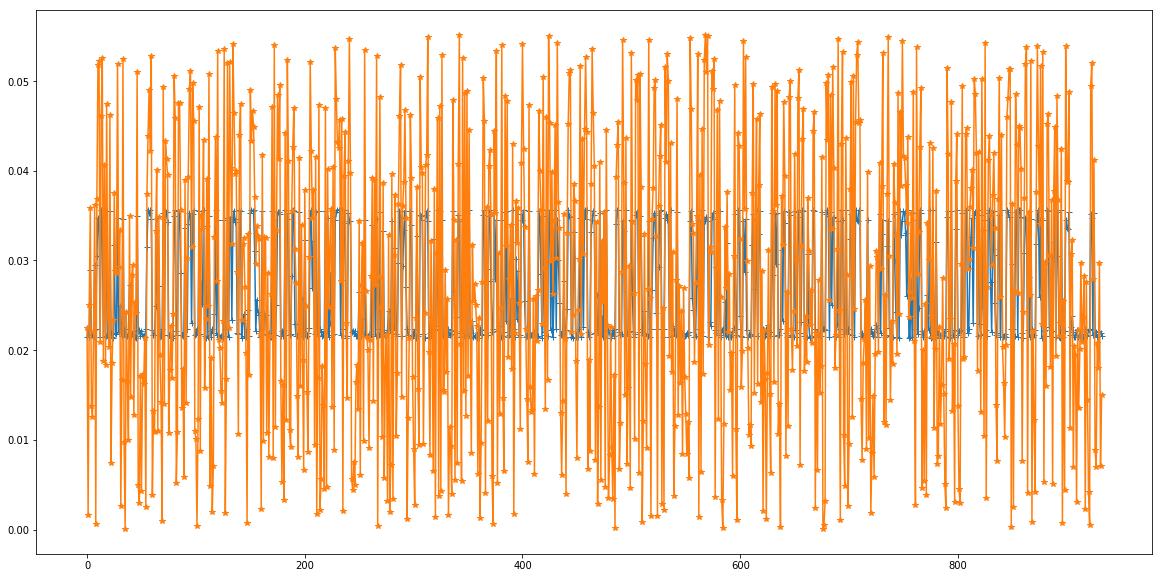

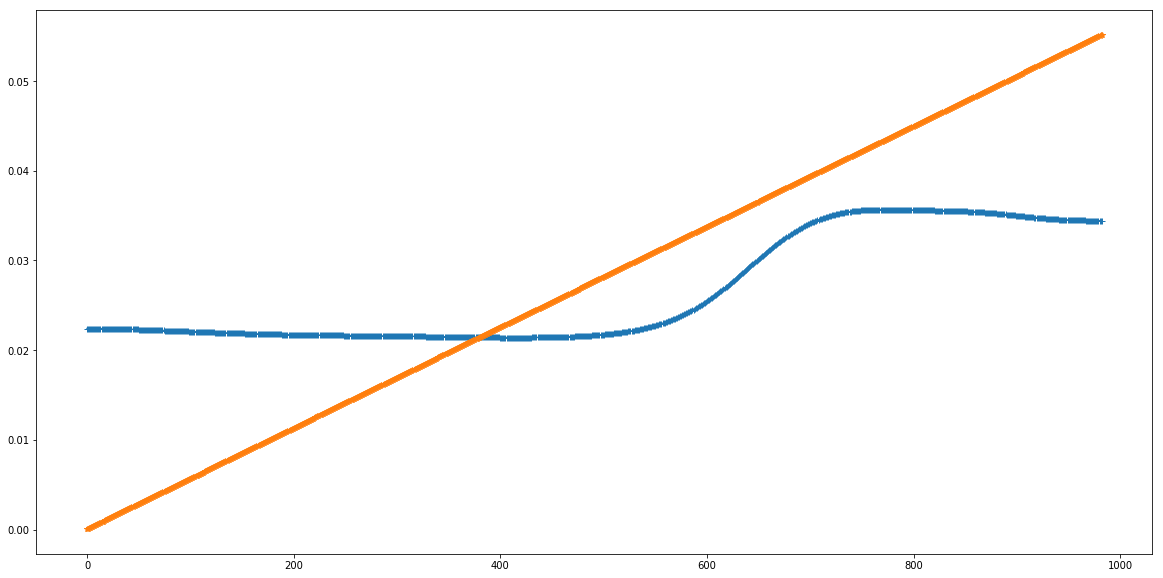

In [41]:
from sklearn import neural_network
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split

nn = neural_network.MLPRegressor(batch_size=16, activation="logistic", hidden_layer_sizes=(2,),
                                 shuffle=False,validation_fraction=0)

final_df1.fillna(method="ffill", inplace=True)
kurt_fitted = kurt_fitted.replace([np.inf, -np.inf], np.nan)

y = final_df1.life_percentage

#normalized life_percenatge
y = preprocessing.normalize([y], norm='l2')
X = final_df1.drop(["life_percentage"], axis=1)


X_train, X_cv, y_train, y_cv = train_test_split(X, y[0], test_size=0.05, random_state=10)


##cross validation set
nn.fit(X_train, y_train)
pred  = nn.predict(X_cv)
print (mean_squared_error(pred, y_cv))
plt.figure(figsize=(20,10))
plt.plot(pred,marker="+",)
plt.plot(y_cv, marker="*")

##train set
pred1  = nn.predict(X_train)
print (mean_squared_error(pred1, y_train))
plt.title("train set")
plt.figure(figsize=(20,10))
plt.plot(pred1, marker="+")
plt.plot(y_train, marker="*")

##Complete Data
pred_fulldata  = nn.predict(X)
print (mean_squared_error(pred_fulldata, y[0]))

plt.figure(figsize=(20,10))
plt.plot(pred_fulldata, marker="+")
plt.plot(y[0], marker="*")



<a id="1_4_2"></a>
#### XGBOOST


('cross validation  :', 1.9273188253966473e-07)
('train set  :', 1.1153602874227065e-07)
('train set  :', 1.1501532005620971e-07)


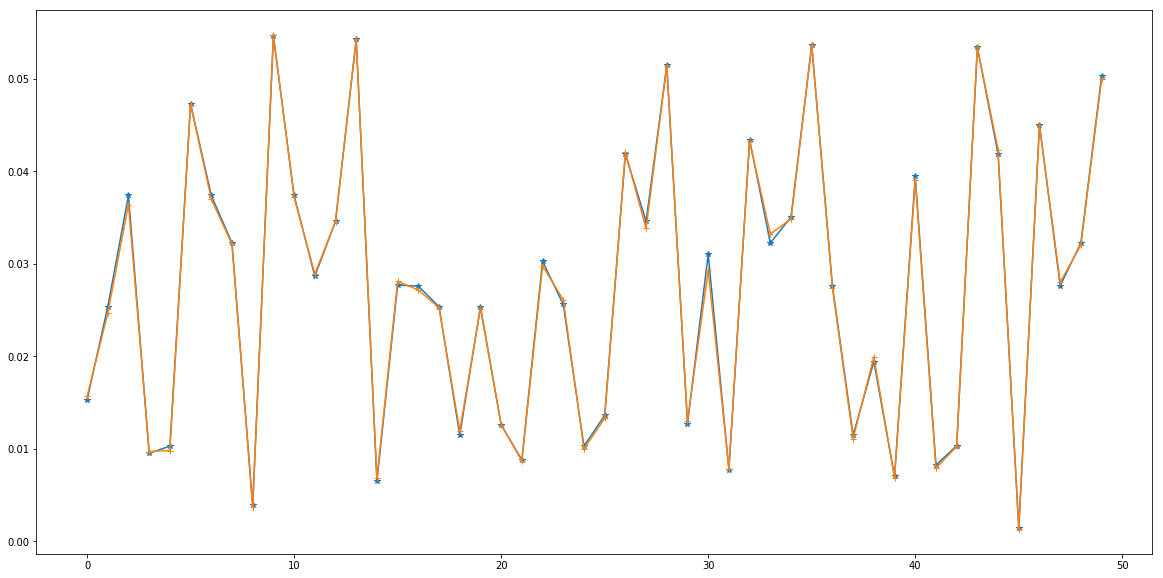

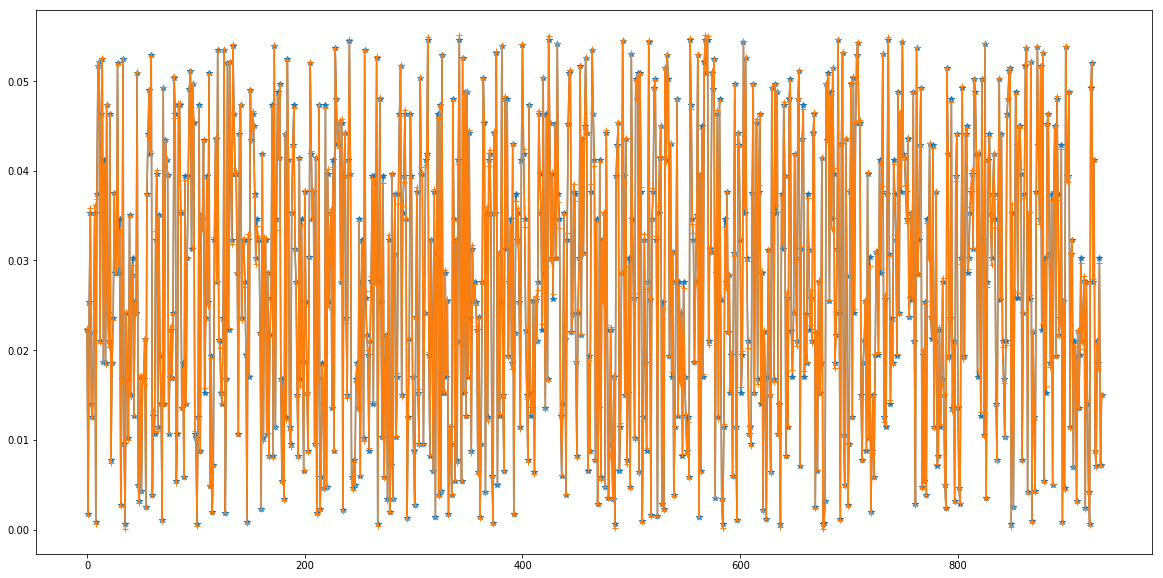

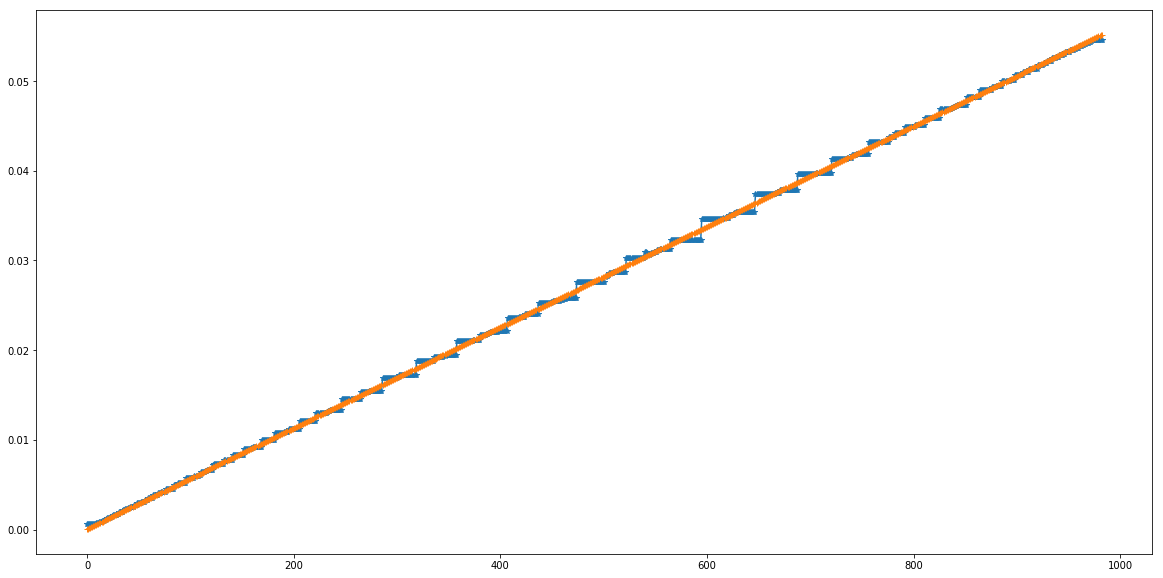

In [32]:
import xgboost as xgb
xgbr = xgb.XGBRegressor()

### validation set
xgbr.fit(X_train, y_train)
pred  = xgbr.predict(X_cv)
print ("cross validation  :" , mean_squared_error(pred, y_cv))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_cv, marker="+")

### train set
xgbr.fit(X_train, y_train)
pred1  = xgbr.predict(X_train)
print ("train set  :", mean_squared_error(pred1, y_train))

plt.figure(figsize=(20,10))
plt.plot(pred1,marker="*",)
plt.plot(y_train, marker="+")


### whole data 
xgbr.fit(X, y[0])
pred_fulldata  = xgbr.predict(X)
print ("train set  :", mean_squared_error(pred_fulldata, y[0]))

plt.figure(figsize=(20,10))
plt.plot(pred_fulldata,marker="*",)
plt.plot(y[0], marker="+")

<a id="1_4_3"></a>
#### LIGHTGBM


('cross validation  :', 7.161138150311898e-09)
('train set  :', 5.184540813220149e-09)
('test set  :', 4.20325240521458e-09)


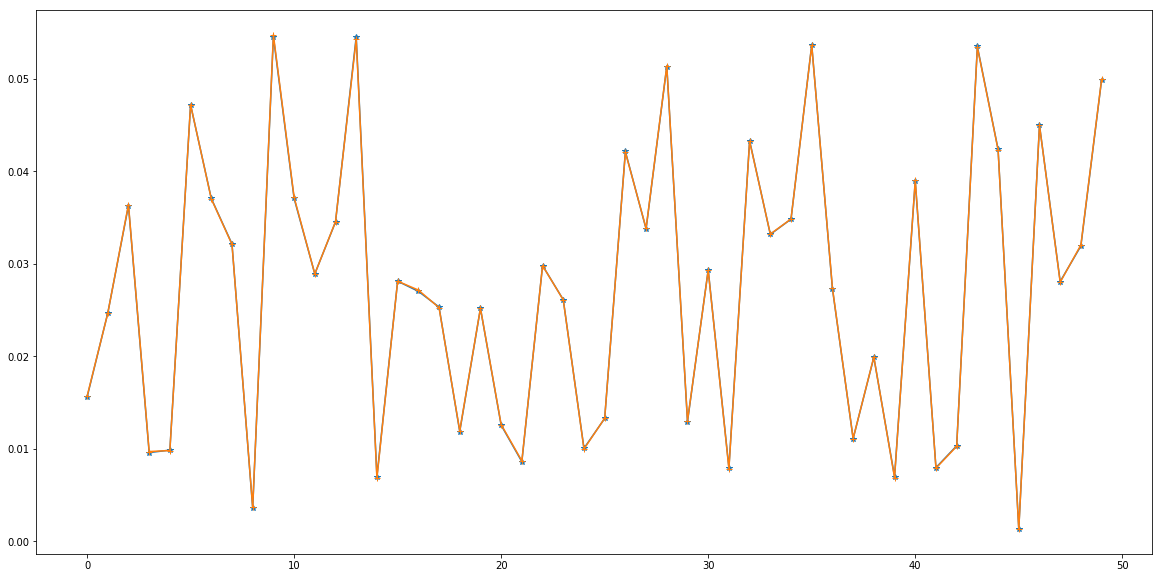

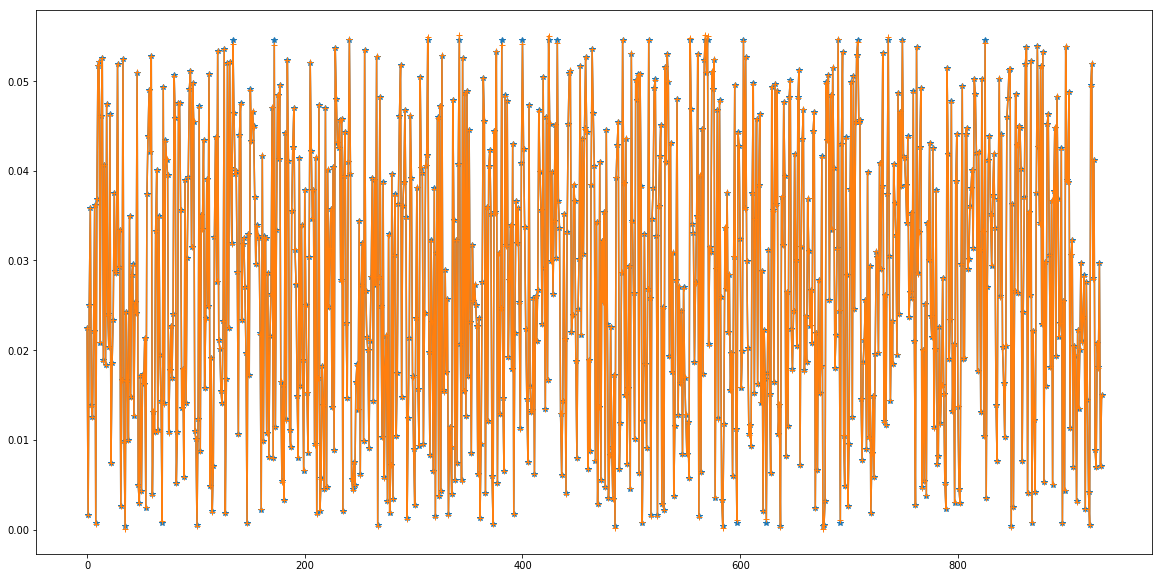

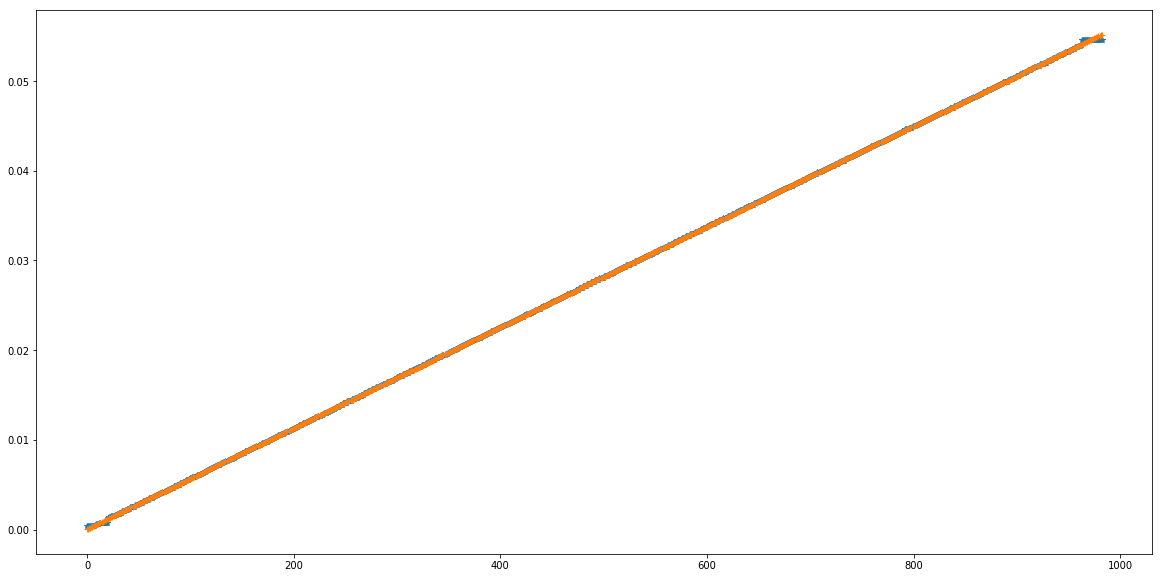

In [33]:
from lightgbm import LGBMRegressor
lgmr = LGBMRegressor()

###Validation set
lgmr.fit(X_train, y_train)
pred  = lgmr.predict(X_cv)
print ("cross validation  :" , mean_squared_error(pred, y_cv))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_cv, marker="+")

###train set
lgmr.fit(X_train, y_train)
pred1  = lgmr.predict(X_train)
print ("train set  :", mean_squared_error(pred1, y_train))

plt.figure(figsize=(20,10))
plt.plot(pred1,marker="*",)
plt.plot(y_train, marker="+")

### ON whole data for checking the fitting
lgmr.fit(X, y[0])
pred_fulldata  = lgmr.predict(X)
print ("test set  :", mean_squared_error(pred_fulldata, y[0]))

plt.figure(figsize=(20,10))
plt.plot(pred_fulldata,marker="*")
plt.plot(y[0], marker="+")

<a id="1_4_4"></a>
#### Gradient Boosting Machine


('cross validation  :', 9.152714248021194e-08)
('train set  :', 9.82419870422861e-08)
('train set  :', 9.809095028865085e-08)


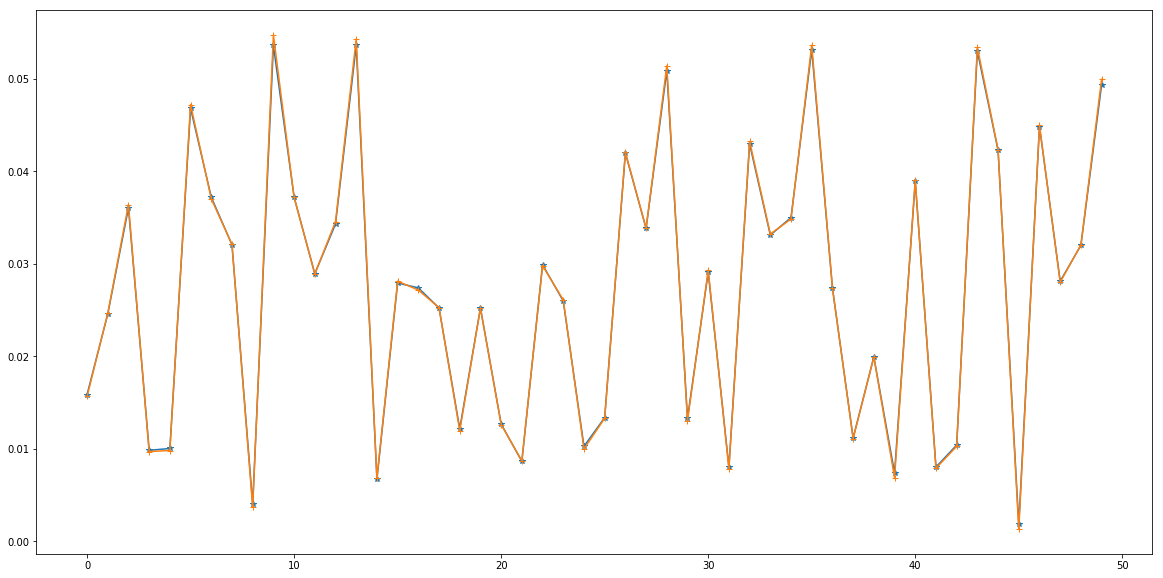

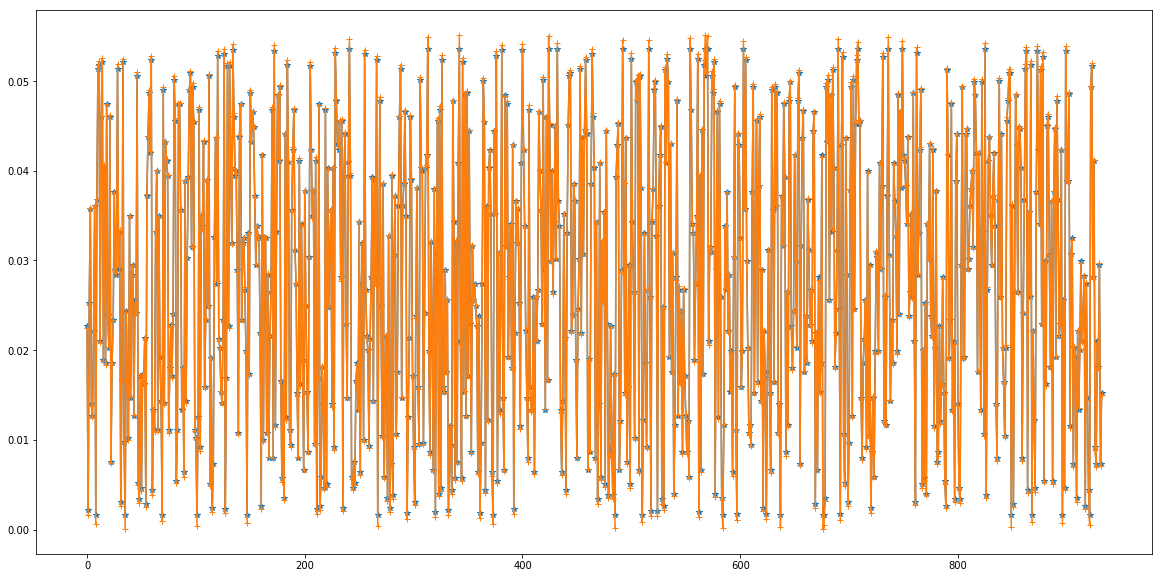

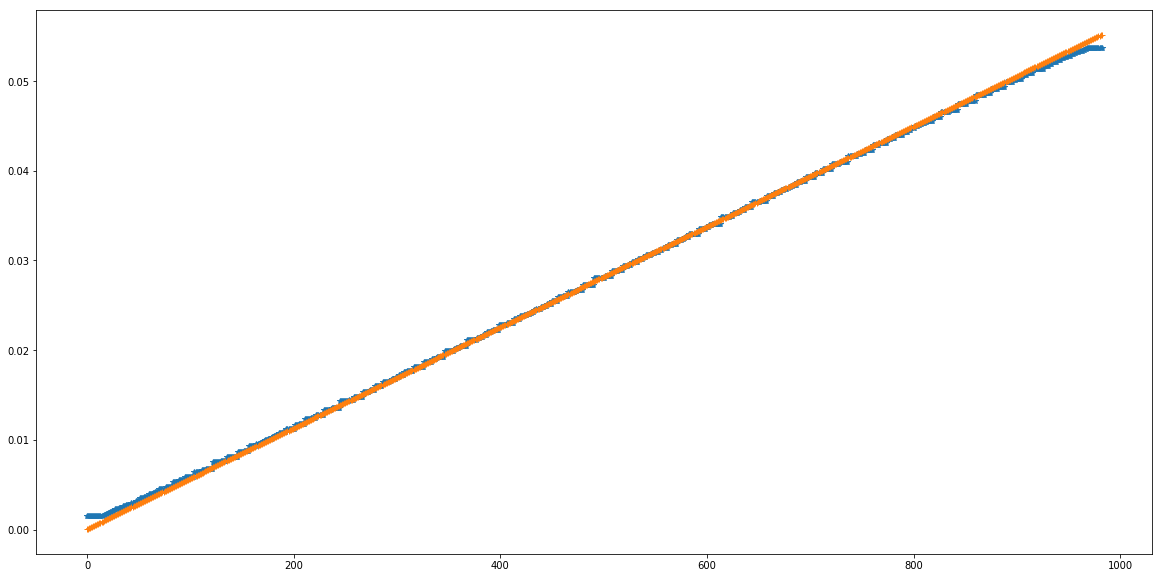

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
gbmr = GradientBoostingRegressor()

#cross validation set
gbmr.fit(X_train, y_train)
pred  = gbmr.predict(X_cv)
print ("cross validation  :" , mean_squared_error(pred, y_cv))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_cv, marker="+")

#train set
gbmr.fit(X_train, y_train)
pred1  = gbmr.predict(X_train)
print ("train set  :", mean_squared_error(pred1, y_train))

plt.figure(figsize=(20,10))
plt.plot(pred1,marker="*",)
plt.plot(y_train, marker="+")


#complete data
gbmr.fit(X, y[0])
pred_fulldata  = gbmr.predict(X)
print ("train set  :", mean_squared_error(pred_fulldata, y[0]))

plt.figure(figsize=(20,10))
plt.plot(pred_fulldata,marker="*",)
plt.plot(y[0], marker="+")

<a id="1_5"></a>
### Performace on Test Set 

[Top](#27017)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y[0], test_size=0.1, random_state=10)

0.00037240888084140905
1.2353270148532476e-07
3.376151243267797e-09
1.0110630170390009e-07


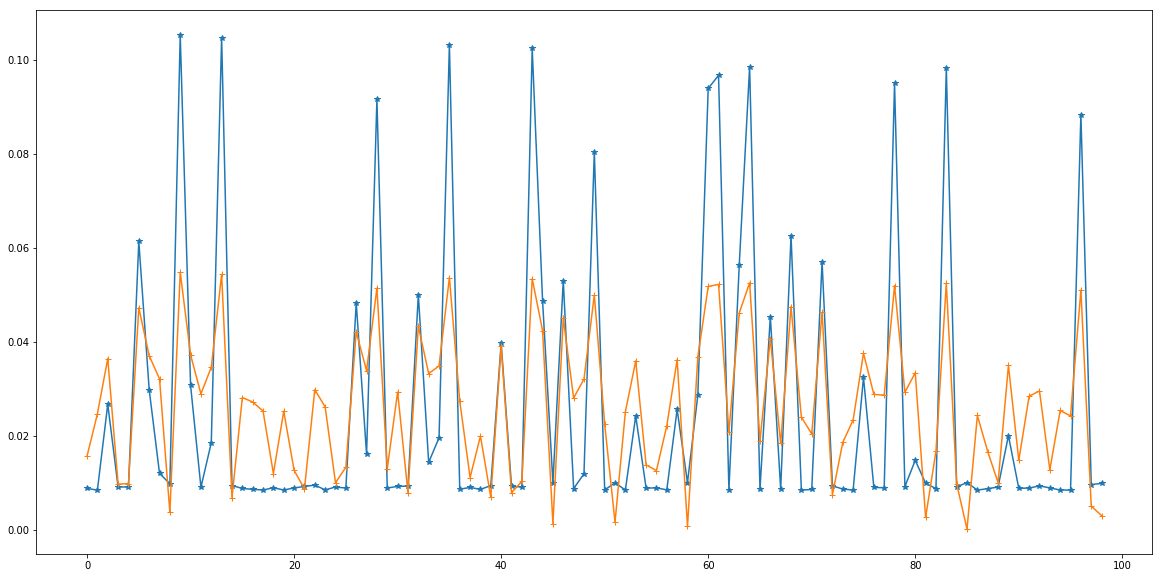

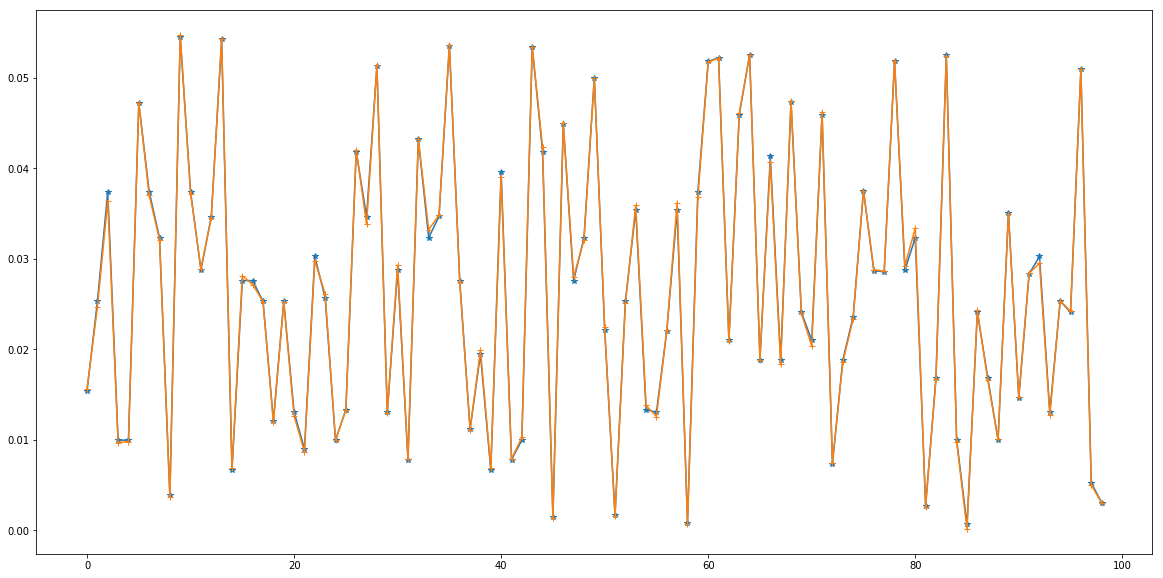

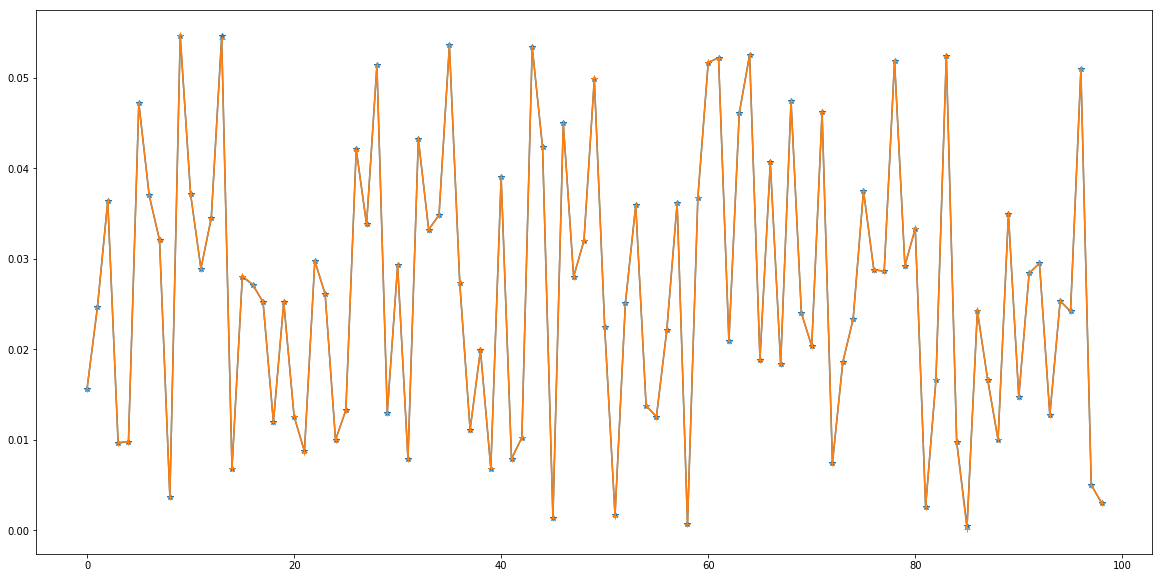

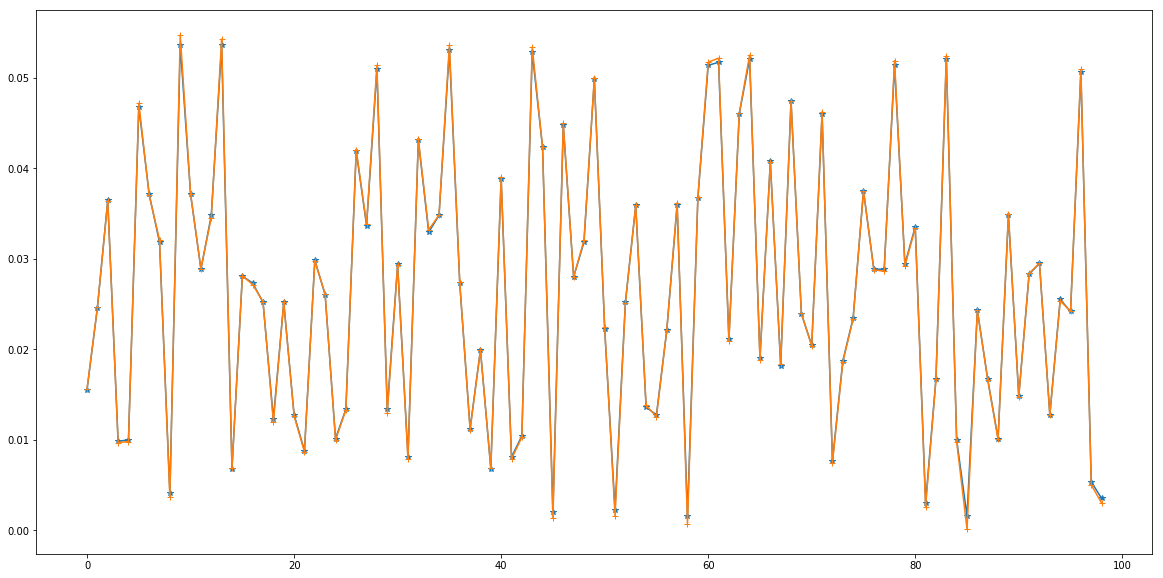

In [36]:
#MLP
pnn = nn.predict(X_test)
print mean_squared_error(pnn,y_test)
plt.figure(figsize=(20,10))
plt.plot(pnn,marker="*",)
plt.plot(y_test, marker="+")

#XGB
pxgbr = xgbr.predict(X_test)
print mean_squared_error(pxgbr,y_test)
plt.figure(figsize=(20,10))
plt.plot(pxgbr,marker="*",)
plt.plot(y_test, marker="+")

#LightGBM
plgbr = lgmr.predict(X_test)
print mean_squared_error(plgbr,y_test)
plt.figure(figsize=(20,10))
plt.plot(plgbr,marker="*",)
plt.plot(y_test, marker="+")

#gbm
pgbmr = gbmr.predict(X_test)
print mean_squared_error(pgbmr,y_test)
plt.figure(figsize=(20,10))
plt.plot(pgbmr,marker="*",)
plt.plot(y_test, marker="+")



<a id="123"></a>
## Deliverable

[Top](#27017)

### `A graph showing RMS & Kurtosis`

#### Check specifically for bearing 1 as mentioned in legend on top-left corner

- [Kurtosis for all 4 Bearings](#1_2_2)
- [Root Mean Square for all 4 bearings](#1_2_3)

### `Weibull Hazard Rate & Parameter Estimates (shape & scale parameter)`

In [74]:
parameterestimates

kurtosis       rms
scale  0.894702  0.119789
shape  1.200772  1.936664

### `Results of training & validation set (as shown in the reference research paper)`

#### Please find the respective grapghs for cross_validation set, Trainset and Complete data Plotted in M
   [Modeling and evaluation](#1_4) for `Bearing1`

_____________________________________
### `Training & Validation error of the proposed model (as shown in the reference research paper)`


#### Multi Layer Perceptron
'cross validation  : 4.002748634182267e-05

'train set  : 4.742223759989163e-05

### ----

#### Extreme Gradient Boosting 
'cross validation  : 4.192865226391459e-08

'train set  : 6.317105818202181e-08

### ----

#### lightGBM
'cross validation  : 2.2127195877270584e-07

'train set  : 2.952020879410212e-07

### ----

#### Gradient Boosting machine
'cross validation  : 1.439480735244331e-07

'train set  : 9.869381155023521e-08


_______________________________________
### `Output performance of test set (as shown in the reference research paper)`

### MLP
Test Set error : 4.2717519115234364e-05

#### XGB
Test Set error : 3.951089941881724e-08

#### LIGHTGBM
Test Set error : 4.7061699229257694e-08

#### GBM
Test Set error : 9.946219161220882e-08


<a id="1_6"></a>
### Modeling for all the 4 bearings


[Top](#27017)

<font color='red'>
As all the bearings are of same type, we can combine all the 4 bearing data frames i.e. final_df1, final_df2, final_df3, final_df4 created using bearing Rms and Kurtosis for all the 4 Bearings as we generated for final_df1
above, reading csv that was generated from the dfs using the code in below cell.
</font>


In [ ]:
#final_data = final_df1.append(final_df2, ignore_index = True).append(final_df3, ignore_index = True).append(final_df4, ignore_index = True)

In [67]:
#for all the 4 bearings
#final_data.to_csv("final_data_all4bearings.csv", sep=",")

path  = os.getcwd()
final_data  = pd.read_csv(path+"/final_data_all4bearings.csv")

#### Multi Layer Perceptron

7.933087975429338e-05


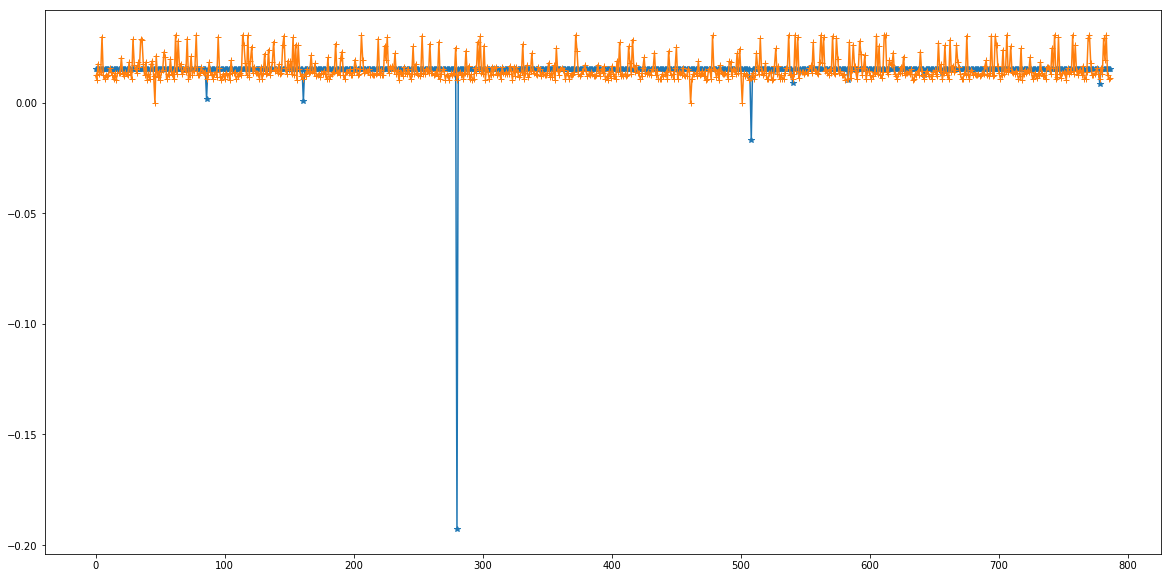

In [104]:
from sklearn import neural_network
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split

nn = neural_network.MLPRegressor(batch_size=16, activation="logistic", hidden_layer_sizes=(2,),
                                 shuffle=False,validation_fraction=0)

y = final_data.life_percentage
y = preprocessing.normalize([y], norm='l2')

X = final_data.drop(["life_percentage"], axis=1)
X.fillna(method="bfill", inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y[0], test_size=0.2, random_state=10)

nn.fit(X_train, y_train)
pred  = nn.predict(X_test)
print (mean_squared_error(pred, y_test))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_test, marker="+")

### Implementing some ensamble models (Trees Based Models)

#### XGBOOST

2.99483546327101e-07


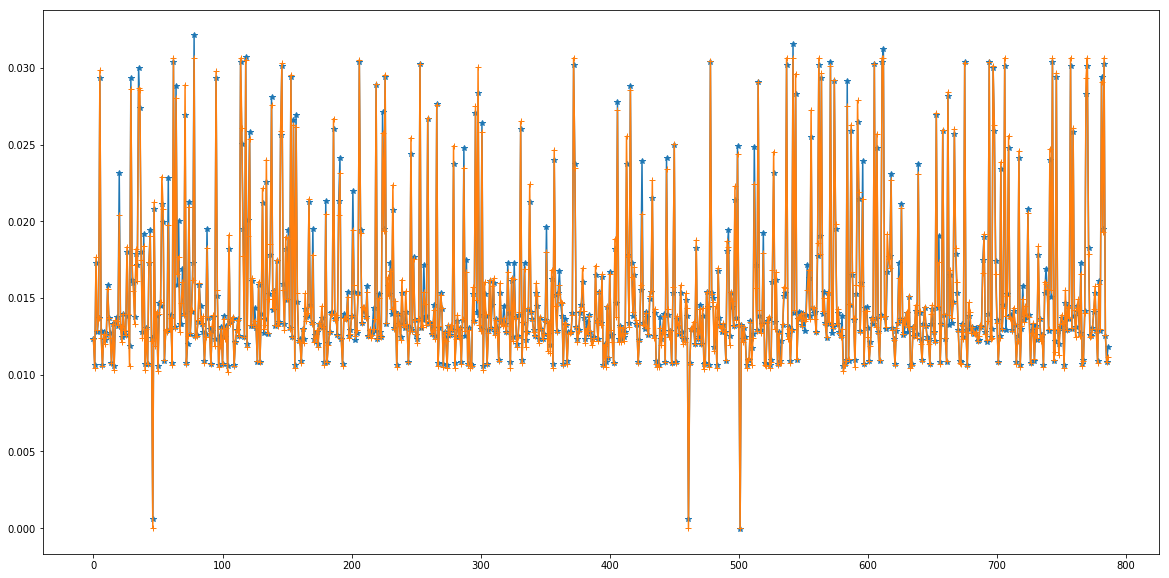

In [105]:
import xgboost as xgb
clf = xgb.XGBRegressor()
clf.fit(X_train, y_train)
pred  = clf.predict(X_test)
print (mean_squared_error(pred, y_test))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_test, marker="+")

#### LIGHTGBM

1.79967626905107e-07


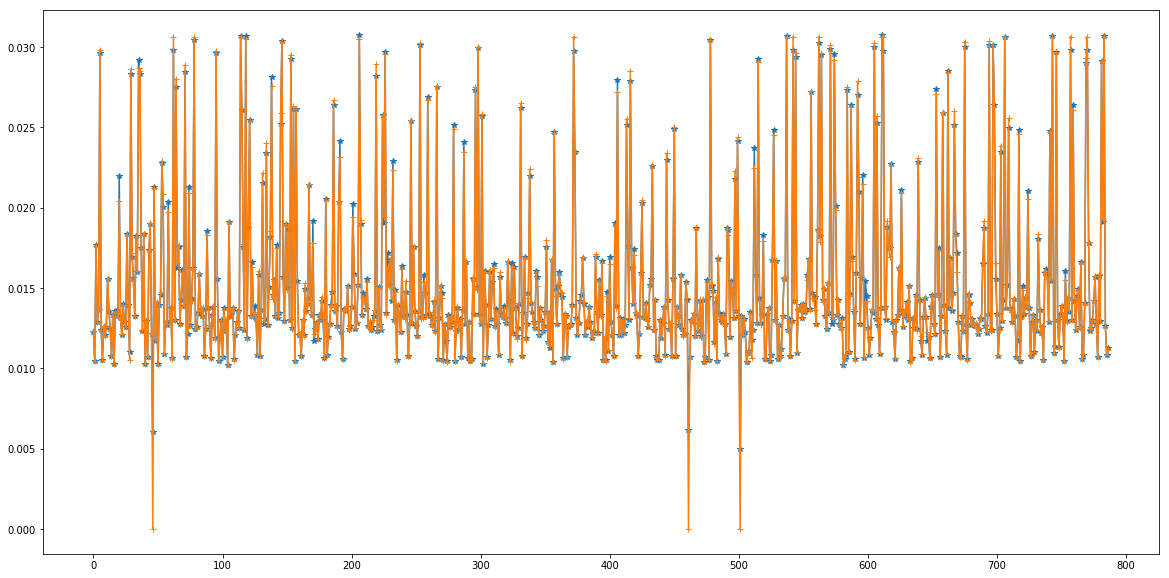

In [106]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(X_train, y_train)
pred  = model.predict(X_test)
print (mean_squared_error(pred, y_test))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_test, marker="+")

#### GRADIENT BOOSTING


3.2195674342611157e-07


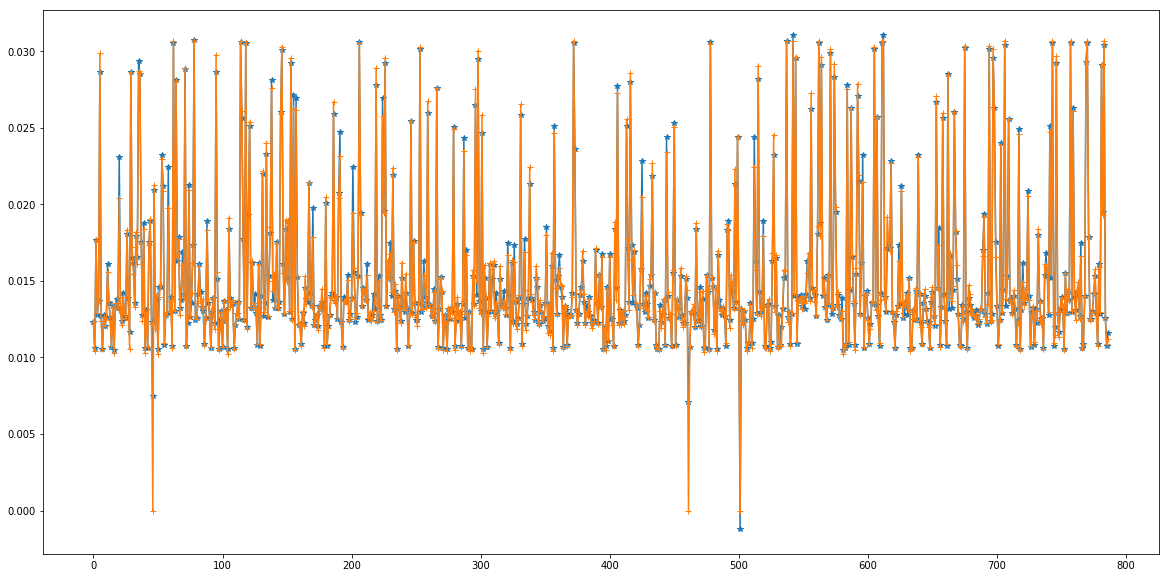

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
pred  = model.predict(X_test)
print (mean_squared_error(pred, y_test))

plt.figure(figsize=(20,10))
plt.plot(pred,marker="*",)
plt.plot(y_test, marker="+")

### `------------------------------------------- END-----------------------------------------`

In [ ]:
##Time-Frequency and Frequncy 

In [ ]:
from scipy.optimize import root
from scipy.stats import norm

from scipy import  signal
#Hilbert Huang transformation
from scipy.signal import hilbert

#short time Fourier transformation
x,y,z = signal.stft(rms_df.rmsB1, fs=1.0, window='hann')

In [ ]:
from scipy import fftpack
f_s = 20000
X = fftpack.fft(rms_df.rmsB1)
freqs = fftpack.fftfreq(len(rms_df.rmsB1)) * f_s

In [ ]:
fig, ax = plt.subplots()
ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

In [ ]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde(rms_df.rmsB1)

In [ ]:
#### Failing values where y is 1
# B1 - 701  - .15 - y 1
# B2 - 891 - 0.11 - y 1
# B3 - 905 - 0.12 - y 1 
# B4 - 921 - 0.08 - y 1

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = 1000
n = N//10
# generate your data sample with N elements
p, x = np.histogram(norm.cdf(np.array(rms_df.rmsB1),np.mean(rms_df.rmsB1), np.std(rms_df.rmsB1)), bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()

In [ ]:
# Frequency-Domain Plot
from scipy.fftpack import fft
yr2 = fft(rms_df.rmsB1) # "raw" FFT with both + and - frequencies
y2 =  rms_df.date_time
plt.figure(figsize=(10,5))
plt.plot( y2, yr2)
plt.xlabel('Time')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain');

In [ ]:
### How to go about prdictive maintainance

When collecting data to support a failure model, it is important to make an inventory the following:
    
What are the types of failure that can occur? Which ones will we try to predict?

How does the “failure process” look like? Is it a slow degradation process or an acute one?

Which parts of the machine/system could be related to each type of failure? What can be 
measured about each of them that reflect their state? How often and with which accuracy
do these measurements need to be performed?


________________________________*****____________________________________________________

What kind of output should the model give?
Is enough historical data available or just static data?

Is every recorded event labelled, i.e. which measurements correspond to good functioning
and which ones correspond to failure? Or at least, 
is it known when each machine failed (if at all)?

When labelled events are available, what is the proportion of the number of events of 
each type of failure and events of well functioning?

How long in advance should the model be able to indicate that a failure will occur?
What are the performance targets that the model should be optimized for? High precision,
high sensitivity/recall, high accuracy? What is the consequence of not predicting a failure or 
predicting a failure that will not happen?

With all this information at hand, we can now decide which modelling strategy fits best to the available data and the desired output, or at least which one is the best candidate to start with. There are multiple modelling strategies for predictive maintenance and we will describe four of them in relation to the question they aim to answer and which kind of data they require:
Regression models to predict remaining useful lifetime (RUL)
Classification models to predict failure within a given time window
Flagging anomalous behaviour
Survival models for the prediction of failure probability over time

Therefore  prognosis  system  is  used  to  predict  the  RUL  time  of  a  machine  failure.

Type of prognosis : 
The  existing  prognosis  or  RUL  prediction  methods  can  be  classified  into  3  categories,
- which  are  physics  based  prognosismodels,
- data  driven  prognosis  models  and
- integration  of  reliability  and  prognosis  system.
    



In [199]:
import numpy
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y